#Visualization and models comparison

In [60]:
!pip install transformers[torch]
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.9 MB/s eta 0:00:00


In [63]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 2.1 MB/s eta 0:00:00


In [2]:
import pandas as pd

In [11]:
df_orig = pd.read_csv("origin_test.csv", index_col=[0])
df_orig.head(5)

,0
0,like the guy with tattoo on his butt?
1,maybe somebody threw a pie in his face.
2,Who's got my goddamn cigarette?
3,"Look, if h.G. Shot her with the same gun That ..."
4,"'all human children will die, Nogusto."


In [12]:
df_flan = pd.read_csv("flan_test.csv", index_col=[0])
df_flan.head(5)

,0
0,Like the guy with tattoo on his butt?
1,Maybe somebody threw a pie in his face.
2,who's got my cigarette?
3,"look, if h.G. shot her with the same gun that ..."
4,"""All human children die, Nogusto."


In [13]:
df_skl = pd.read_csv("skolkovo_test.csv", index_col=[0])
df_skl.head(5)

,0
0,Like the guy with the tattoo on his butt?
1,Maybe someone threw a pie in his face.
2,who's got my cigarette?
3,"look, if h.G. shot her with the same gun she u..."
4,"'All human children die, Nogusto."


In [14]:
df_t5 = pd.read_csv("t5_test.csv", index_col=[0])
df_t5.head(5)

,0
0,like the guy with tattoo on his butt?
1,Maybe someone threw a pie in his face.
2,who's got my cigarette?
3,"look, if h.G. shot her with the same gun that ..."
4,"""all human children die, Nogusto."


In [23]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer
import torch
import numpy as np
clf_name = 'SkolkovoInstitute/roberta_toxicity_classifier_v1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clf = RobertaForSequenceClassification.from_pretrained(clf_name).to(device);
clf_tokenizer = RobertaTokenizer.from_pretrained(clf_name)

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier_v1 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
def predict_toxicity(texts):
    with torch.inference_mode():
        inputs = clf_tokenizer(texts, return_tensors='pt', padding=True).to(clf.device)
        out = torch.softmax(clf(**inputs).logits, -1)[:, 1].cpu().numpy()
    return out

In [64]:
from datasets import load_dataset, load_metric
# Load the BLUE metric
metric = load_metric("sacrebleu")

In [27]:
orig_toxicity = []
for i in range(len(df_orig)):
    sentence = df_orig.iloc[i]['0']
    orig_toxicity.append(predict_toxicity(sentence))

orig_toxicity = np.array(orig_toxicity)

In [29]:
np.mean(orig_toxicity)

0.912228

In [79]:
flan_toxicity = []
flan_bleu = []
for i in range(len(df_flan)):
    sentence = df_flan.iloc[i]['0']
    flan_toxicity.append( predict_toxicity(sentence))
    flan_bleu.append(metric.compute(predictions=[sentence], references=[[df_orig.iloc[i]['0']]])['score'])

flan_toxicity = np.array(flan_toxicity)
flan_bleu = np.array(flan_bleu)

In [80]:
np.mean(flan_toxicity)

0.56572354

In [81]:
np.mean(flan_bleu)

67.49646646826696

In [82]:
t5_toxicity = []
t5_bleu = []
for i in range(len(df_t5)):
    sentence = df_t5.iloc[i]['0']
    t5_toxicity.append(predict_toxicity(sentence))
    t5_bleu.append(metric.compute(predictions=[sentence], references=[[df_orig.iloc[i]['0']]])['score'])

t5_toxicity = np.array(t5_toxicity)
t5_bleu = np.array(t5_bleu)

In [83]:
np.mean(t5_toxicity)

0.5776659

In [84]:
np.mean(t5_bleu)

67.66216766883211

In [85]:
skl_toxicity = []
skl_bleu = []
for i in range(len(df_skl)):
    sentence = df_skl.iloc[i]['0']
    skl_toxicity.append(predict_toxicity(sentence))
    skl_bleu.append(metric.compute(predictions=[sentence], references=[[df_orig.iloc[i]['0']]])['score'])

skl_toxicity = np.array(skl_toxicity)
skl_bleu = np.array(skl_bleu)

In [86]:
np.mean(skl_toxicity)

0.3647479

In [87]:
np.mean(skl_bleu)

56.61599198411918

Now let's plot the result


In [36]:
import matplotlib.pyplot as plt

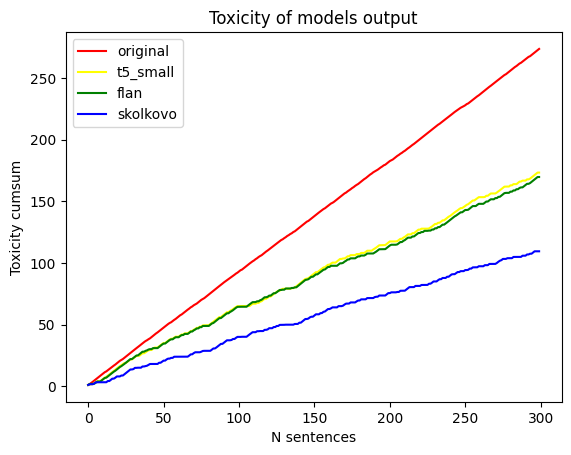

In [46]:
plt.plot(np.cumsum(orig_toxicity), color = 'red', label = "original")
plt.plot(np.cumsum(t5_toxicity), color = 'yellow', label ="t5_small")
plt.plot(np.cumsum(flan_toxicity), color = 'g', label = "flan")
plt.plot(np.cumsum(skl_toxicity), color = 'b', label ="skolkovo")
plt.legend()
plt.xlabel("N sentences")
plt.ylabel("Toxicity cumsum")
plt.title("Toxicity of models output")
plt.show()

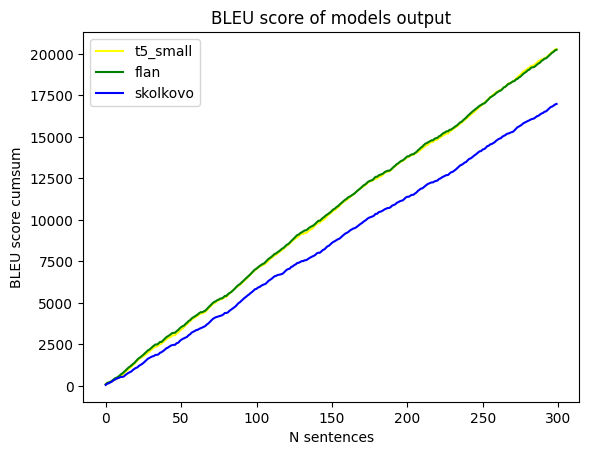

In [89]:
plt.plot(np.cumsum(t5_bleu), color = 'yellow', label ="t5_small")
plt.plot(np.cumsum(flan_bleu), color = 'g', label = "flan")
plt.plot(np.cumsum(skl_bleu), color = 'b', label ="skolkovo")
plt.legend()
plt.xlabel("N sentences")
plt.ylabel("BLEU score cumsum")
plt.title("BLEU score of models output")
plt.show()

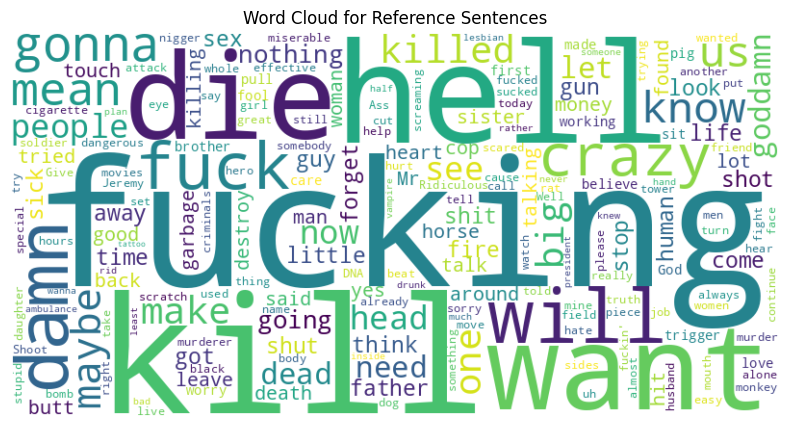

In [48]:
from wordcloud import WordCloud
ref_text = ' '.join(df_orig['0'])
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(ref_text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Reference Sentences')
plt.show()

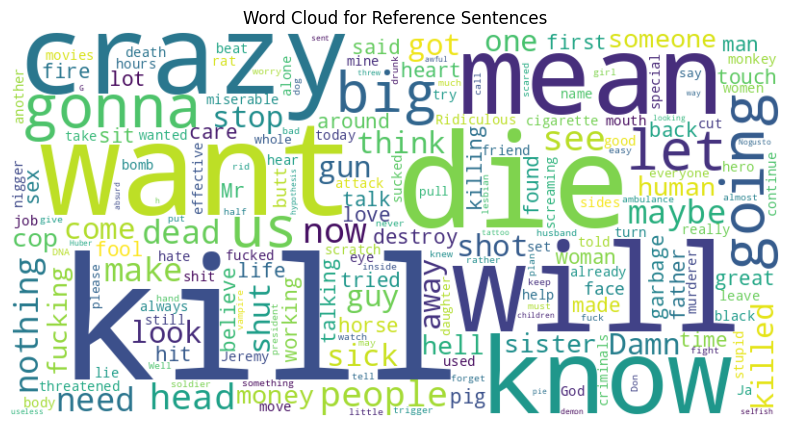

In [49]:
from wordcloud import WordCloud
ref_text = ' '.join(df_t5['0'])
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(ref_text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Reference Sentences')
plt.show()

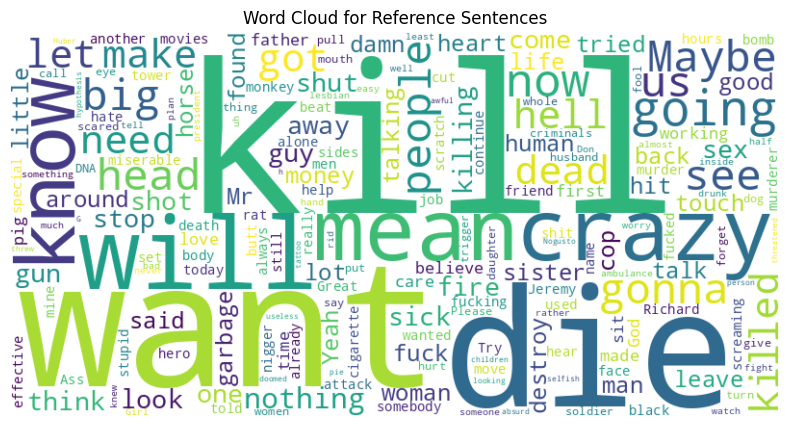

In [50]:
from wordcloud import WordCloud
ref_text = ' '.join(df_flan['0'])
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(ref_text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Reference Sentences')
plt.show()

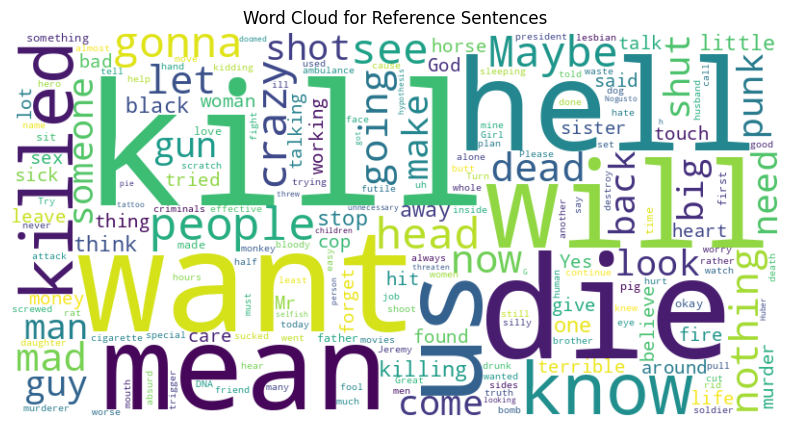

In [51]:
from wordcloud import WordCloud
ref_text = ' '.join(df_skl['0'])
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(ref_text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Reference Sentences')
plt.show()